# Colour Difference

In this notebook, two colour spaces will be used (RGB and YIQ). The mean of each channel will be extracted creating 3 vectors with shape 3. Then, the euclidean distance will be calculated and converted in the range 1, 4

In [1]:
from ipynb.fs.full.functools import Cases, np, plt, mpl
from typing import List
from statistics import mean
cases = Cases()
%matplotlib inline

##### AK before treatment

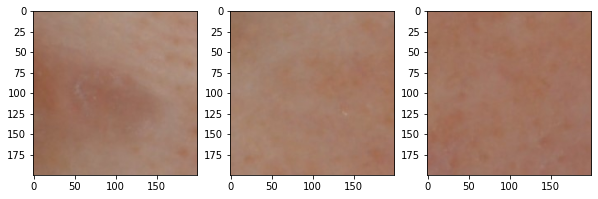

In [2]:
case = 'CASE18'

case_before = cases.before[case]

plt.figure(figsize=(10, 5))
plt.subplot(131); plt.imshow(case_before[0])
plt.subplot(132); plt.imshow(case_before[1])
plt.subplot(133); plt.imshow(case_before[2])
plt.show()

##### AK after treatment

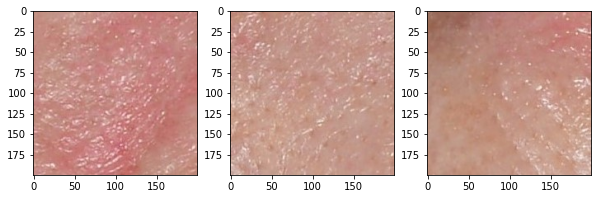

In [3]:
case_after = cases.after[case]

plt.figure(figsize=(10, 5))
plt.subplot(131); plt.imshow(case_after[0])
plt.subplot(132); plt.imshow(case_after[1])
plt.subplot(133); plt.imshow(case_after[2])
plt.show()

## Using RGB channels

Extract the mean of RGB channels and then calculate the euclidean distance.

In [4]:
def euclidean_distance(p, q):
    dist = np.sqrt(np.sum(np.square(p-q)))
    return dist

def get_means_of_channels(image: np.ndarray) -> np.ndarray:
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]
    
    return np.array([np.mean(R), np.mean(G), np.mean(B)])

In [5]:
# before image
wound = get_means_of_channels(case_before[0])
n_sk1 = get_means_of_channels(case_before[1])
n_sk2 = get_means_of_channels(case_before[2])

print(f"wound and sk1: \t{euclidean_distance(wound, n_sk1)}")
print(f"wound and sk2: \t{euclidean_distance(wound, n_sk2)}")
print(f"sk1 and sk2: \t{euclidean_distance(n_sk1, n_sk2)}")

print(f"\naverage is {mean([euclidean_distance(wound, n_sk2), euclidean_distance(wound, n_sk1)]):.2f}")

wound and sk1: 	3.404933154354877
wound and sk2: 	13.950899494051443
sk1 and sk2: 	15.386987021343721

average is 8.68


In [6]:
# after image
wound = get_means_of_channels(case_after[0])
n_sk1 = get_means_of_channels(case_after[1])
n_sk2 = get_means_of_channels(case_after[2])

print(f"wound and sk1: \t{euclidean_distance(wound, n_sk1)}")
print(f"wound and sk2: \t{euclidean_distance(wound, n_sk2)}")
print(f"sk1 and sk2: \t{euclidean_distance(n_sk1, n_sk2)}")

print(f"\naverage is {mean([euclidean_distance(wound, n_sk2), euclidean_distance(wound, n_sk1)]):.2f}")

wound and sk1: 	18.990499967582487
wound and sk2: 	9.750419168778075
sk1 and sk2: 	16.437404823317618

average is 14.37


### YIQ

In [8]:
# transform images in YIQ using skimage

from skimage.color import yiq2rgb, rgb2lab

case_yiq_before = [yiq2rgb(img) for img in case_before]

In [9]:
# before image
wound = get_means_of_channels(case_yiq_before[0])
n_sk1 = get_means_of_channels(case_yiq_before[1])
n_sk2 = get_means_of_channels(case_yiq_before[2])

print(f"wound and sk1: \t{euclidean_distance(wound, n_sk1)}")
print(f"wound and sk2: \t{euclidean_distance(wound, n_sk2)}")
print(f"sk1 and sk2: \t{euclidean_distance(n_sk1, n_sk2)}")

print(f"\naverage is {mean([euclidean_distance(wound, n_sk2), euclidean_distance(wound, n_sk1)]):.2f}")

wound and sk1: 	0.01991094362147327
wound and sk2: 	0.0781887814878852
sk1 and sk2: 	0.08956031899639387

average is 0.05


In [10]:
case_yiq_after = [yiq2rgb(img) for img in case_after]

# after image
wound = get_means_of_channels(case_yiq_after[0])
n_sk1 = get_means_of_channels(case_yiq_after[1])
n_sk2 = get_means_of_channels(case_yiq_after[2])

print(f"wound and sk1: \t{euclidean_distance(wound, n_sk1)}")
print(f"wound and sk2: \t{euclidean_distance(wound, n_sk2)}")
print(f"sk1 and sk2: \t{euclidean_distance(n_sk1, n_sk2)}")

print(f"\naverage is {mean([euclidean_distance(wound, n_sk2), euclidean_distance(wound, n_sk1)]):.2f}")

wound and sk1: 	0.09366637376299945
wound and sk2: 	0.0765142047719618
sk1 and sk2: 	0.10787156628040187

average is 0.09


## LAB

In [11]:
# transform images in YIQ using skimage

from skimage.color import rgb2lab

case_lab_before = [rgb2lab(img) for img in case_before]
case_lab_after = [rgb2lab(img) for img in case_after]


In [12]:
# before image
wound = get_means_of_channels(case_lab_before[0])
n_sk1 = get_means_of_channels(case_lab_before[1])
n_sk2 = get_means_of_channels(case_lab_before[2])

print(f"wound and sk1: \t{euclidean_distance(wound, n_sk1)}")
print(f"wound and sk2: \t{euclidean_distance(wound, n_sk2)}")
print(f"sk1 and sk2: \t{euclidean_distance(n_sk1, n_sk2)}")

print(f"\naverage is {mean([euclidean_distance(wound, n_sk2), euclidean_distance(wound, n_sk1)]):.2f}")

wound and sk1: 	1.4909262635634655
wound and sk2: 	5.042508183443183
sk1 and sk2: 	5.08138704231123

average is 3.27


In [13]:
# after image
wound = get_means_of_channels(case_lab_after[0])
n_sk1 = get_means_of_channels(case_lab_after[1])
n_sk2 = get_means_of_channels(case_lab_after[2])

print(f"wound and sk1: \t{euclidean_distance(wound, n_sk1)}")
print(f"wound and sk2: \t{euclidean_distance(wound, n_sk2)}")
print(f"sk1 and sk2: \t{euclidean_distance(n_sk1, n_sk2)}")

print(f"\naverage is {mean([euclidean_distance(wound, n_sk2), euclidean_distance(wound, n_sk1)]):.2f}")

wound and sk1: 	9.139278751276844
wound and sk2: 	7.031873709881236
sk1 and sk2: 	4.11634400261533

average is 8.09
